In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import seaborn as sns
from tqdm import tqdm
sns.set(style='white', context='talk', palette='colorblind')

from behavior_model_fitting.helpers.policy import softmax 

In [2]:
# load data
data=pd.read_pickle('../data/BernoulliBanditData.pickel')#, converters={'outcomes':converter})

# Bayesian Hyperparameter Search for learning model parameters

## per subject

In [3]:
import ax
from behavior_model_fitting.models import Qlearner
# from ax.plot.contour import plot_contour
# from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize

In [4]:
n_trials = 1000
n_iters = 10
subj=0
n_subjects = 1
n_options = 2
outcomes = data.outcomes[:n_subjects]
actions = torch.as_tensor(data.actions).type(torch.LongTensor)
Qinit = [0.5, 0.5]
nll_loss = torch.nn.NLLLoss(reduction='sum')
R = torch.nn.functional.one_hot(torch.arange(n_options), num_classes=n_options)

In [7]:
def compute_nll_per_subject(parameters):
    model = Qlearner(**parameters)
    q = model.Qinit
    #print(model.lr, model.beta)
    log_softmax = []
    
    for trial in range(n_trials):
        a_t = actions[subj][trial]
        log_softmax.append(model.log_softmax(q))
        r_t = R[a_t]*outcomes[subj][trial][a_t]
        q = model(r_t, Q=q)

    log_softmax = torch.stack(log_softmax)
    loss = nll_loss(log_softmax, actions[subj])
    return float(loss.data.numpy())

In [8]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [0.01, 1.], 'value_type':'float', "log_scale": True},
        {"name": "beta", "type": "range", 'value_type':'float', "bounds": [1e-1, 20.]}
    ],
    evaluation_function=compute_nll_per_subject,
    objective_name='nll',
    total_trials=n_iters, minimize=True
)

[INFO 05-05 13:33:09] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 05-05 13:33:09] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 05-05 13:33:09] ax.service.managed_loop: Running optimization trial 1...
[INFO 05-05 13:33:09] ax.service.managed_loop: Running optimization trial 2...
[INFO 05-05 13:33:09] ax.service.managed_loop: Running optimization trial 3...
[INFO 05-05 13:33:09] ax.service.managed_loop: Running optimization trial 4...
[INFO 05-05 13:33:09] ax.service.managed_loop: Running optimization trial 5...
[INFO 05-05 13:33:09] ax.service.managed_loop: Running optimization trial 6...
[INFO 05-05 13:33:11] ax.service.managed_loop: Running optimization trial 7...
[INFO 05-05 13:33:14] ax.service.managed_loop: Running optimization trial 8...
[INFO 05-05 

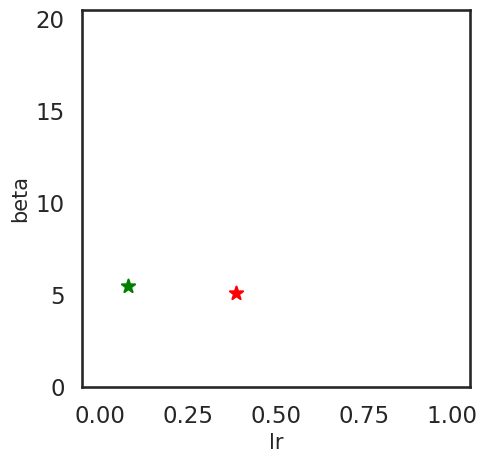

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.scatter(data.loc[subj].true_lr, data.loc[subj].true_beta, c='green', marker='*', s=100)
ax.scatter(best_parameters['lr'], best_parameters['beta'], c='red', marker='*', s=100)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([0., 20.5])
ax.set_ylabel(ylabel='beta', fontsize=15)
ax.set_xlabel(xlabel='lr', fontsize=15)
plt.show()

## population fits

# Minimize negative log-likelihoood using gradient descent

In [10]:
from behavior_model_fitting.models import Qlearner
import torch.nn as nn
import torch.optim as optim
from behavior_model_fitting.helpers.measures import nll_per_model_per_subject

## recovery of model parameters per subject

In [24]:
n_epochs = 100
n_trials = 1000
Q_init = [0., 0.]
model = Qlearner(Qinit=Q_init, beta=5.)
nll_loss = torch.nn.NLLLoss()
SUBJ = 0
outcomes = data.outcomes[SUBJ]
actions = torch.as_tensor(data.actions[SUBJ].astype('int'))#[:10]
optimizer = optim.Adam(model.parameters(), lr=0.001)    
R = torch.nn.functional.one_hot(torch.arange(2),num_classes=2)

In [25]:
print('initial parameters: lr {}, beta {}'.format(model.lr.data, model.beta.data))

initial parameters: lr 0.009999999776482582, beta 5.0


### Choosing a loss function
1. NLL - helps find parameters which result in matching subject behavior
2. MSE - used to find parameters which result in highest reward per trial
3. Cross-entropy - improve classification or choosing arm probability

In [26]:
for epoch in range(n_epochs):
    # epochs
    q = model.Qinit
    log_softmax = []
    for trial in range(n_trials):
    # trials
        a_t = actions[trial]
        log_softmax.append(model.log_softmax(q))
        r_t = R[a_t]*outcomes[trial][a_t]
        q = model(r_t, Q=q)
       
    log_softmax = torch.stack(log_softmax)
    loss = nll_loss(log_softmax, actions)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [27]:
print('true parameters: lr {}, beta {}'.format(data.loc[SUBJ].true_lr, data.loc[SUBJ].true_beta))
print('fit parameters: lr {}, beta {}'.format(model.lr.data, model.beta.data))
NLL, qvalues = nll_per_model_per_subject(outcomes, torch.tensor(Q_init), model.lr.data, model.beta.data, actions)
print('NLL {}'.format(NLL))

true parameters: lr 0.0793807787701838, beta 5.4926469042339745
fit parameters: lr 0.0551292710006237, beta 4.892154216766357
NLL 26.937976837158203


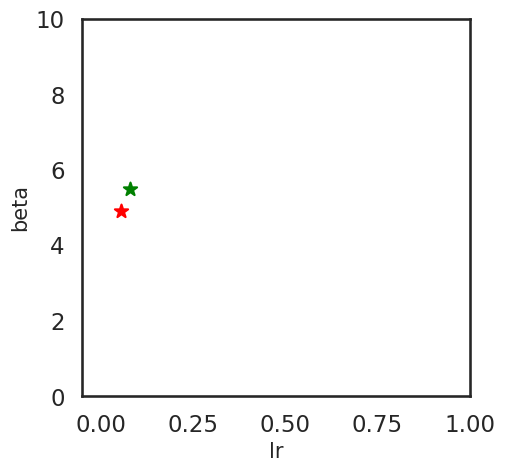

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.scatter(data.loc[SUBJ].true_lr, data.loc[SUBJ].true_beta, c='green', marker='*', s=100)
ax.scatter(model.lr.data, model.beta.data, c='red', marker='*', s=100)
ax.set_xlim([-0.05, 1])
ax.set_ylim([0., 10])
ax.set_ylabel(ylabel='beta', fontsize=15)
ax.set_xlabel(xlabel='lr', fontsize=15)
plt.show()

## recovery of model parameters for population

In [19]:
n_epochs = 100
n_trials = 1000
n_subjects = 3
n_options = 2

outcomes = data.outcomes[:n_subjects]
actions = torch.as_tensor(data.actions).type(torch.LongTensor)
Q_init = [0.5, 0.5]
optim_lr = 0.001
model = Qlearner(Qinit=Q_init)

nll_loss = torch.nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=optim_lr)    
R = torch.nn.functional.one_hot(torch.arange(n_options), num_classes=n_options)
lrs, betas = [], []

In [21]:
for subj in range(n_subjects):
    model.__init__()
    for epoch in tqdm(range(n_epochs)):
        # number of epochs
        q = model.Qinit
        log_softmax = []
        for trial in range(n_trials):
        # number of trials
            a_t = actions[subj][trial]
            log_softmax.append(model.log_softmax(q))
            r_t = R[a_t]*outcomes[subj][trial][a_t]
            q = model(r_t, Q=q)

        log_softmax = torch.stack(log_softmax)
        loss = nll_loss(log_softmax, actions[subj])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    #print('fitted model to subject {} of {}'.format(subj+1, n_subjects))
    lrs.append(model.lr.data)
    betas.append(model.beta.data)

100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


In [22]:
lrs = torch.stack(lrs)
betas = torch.stack(betas)

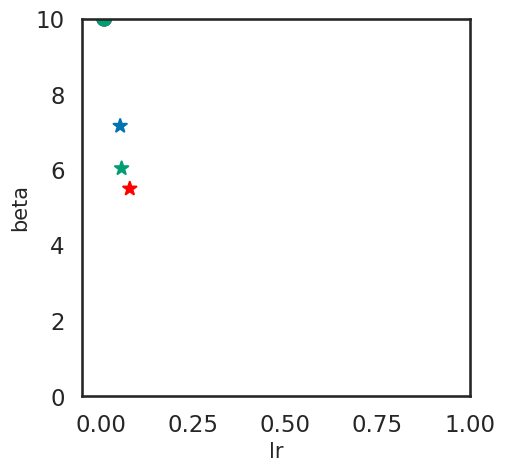

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.scatter(data.loc[[0,1,2]].true_lr, data.loc[[0,1,2]].true_beta, c=['red', 'b', 'g'], marker='*', s=100)
ax.scatter(lrs, betas, c=['red', 'b', 'g'], marker='o', s=100)
ax.set_xlim([-0.05, 1])
ax.set_ylim([0., 10])
ax.set_ylabel(ylabel='beta', fontsize=15)
ax.set_xlabel(xlabel='lr', fontsize=15)
plt.show()

 # Grid-search for parameter recovery

### compute NLL per subj per paramter

In [29]:
subj = 0
lr = 0.01
beta = 0.1
outcome = data.outcomes[subj]
choice = data.actions[subj].astype('int')
action = data.actions[subj].astype('int')
q_init = torch.as_tensor([0.5, 0.5]) #data.true_Qinit[subj])
return_qvalues=True

In [10]:
def nll_per_model_per_subject(outcomes, q, lr, beta, choice, ntrials=100, return_qvalues=False):
    nll = 0.
    qvalues = []
    for trial in range(ntrials):
        a_t = choice[trial]
        nll += -(q[a_t]*beta - torch.log(torch.exp(q*beta).sum()))
        r_t = outcomes[trial][a_t]
        q[a_t] = q[a_t] + lr*(r_t-q[a_t])
        qvalues.append(q.clone().detach())
    if return_qvalues:
        return nll
    else:
        return nll, qvalues

In [16]:
NLL, qvalues = nll_per_model_per_subject(outcome, q_init, lr, beta, action, return_qvalues)

### temporal development of q-values 

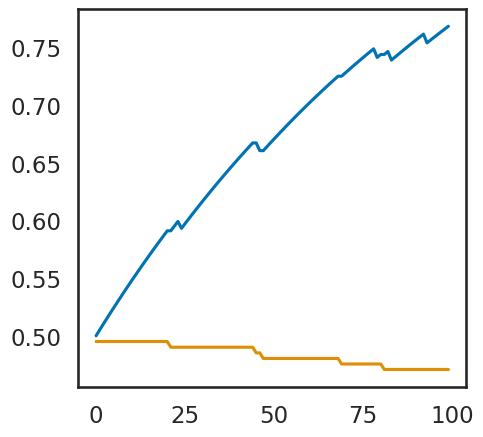

In [17]:
fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=100)
plt.plot(torch.stack(qvalues).data.numpy())
plt.show()

Note: While computing the gradient for negative log-likelihood (NLL), it is important to note that gradient of NLL wrt learning rate resets to 0 everytime the agents switches action. 

### compute NLL per subj per model across parameters

In [29]:
from matplotlib.colors import LogNorm, SymLogNorm

In [30]:
nparams = 100
nsubj = 1
beta_range = [0.01, 20]
lr_range = [0.01, 1.]
betas = np.linspace(beta_range[0], beta_range[1], nparams)
lrs = np.linspace(lr_range[0], lr_range[1], nparams)
NLLS = np.zeros((nsubj, nparams, nparams))

In [31]:
def nll_per_model_per_subject(outcomes, q, lr, beta, choice, ntrials=100):
    nll = 0.
    qq = []
    for trial in range(ntrials):
        a_t = choice[trial]
        nll += -(q[a_t]*beta - torch.log(torch.exp(q*beta).sum()))
        r_t = outcomes[trial][a_t]
        q[a_t] = q[a_t] + lr*(r_t-q[a_t])
        
    return nll

In [32]:
for subj in range(nsubj):
    for ix, lr in enumerate(lrs): 
        for iy, beta in enumerate(betas):
            NLLS[subj, ix, iy] = nll_per_model_per_subject(data.outcomes[subj],torch.tensor(data.true_Qinit[subj]), lr, beta, data.actions[subj].astype('int'))

In [34]:
SUBJ=0
best_lr_idx, best_beta_idx =np.unravel_index(NLLS[SUBJ].argmin(), NLLS[SUBJ].shape)
print('true parameters: lr {}, beta {}'.format(data.loc[SUBJ].true_lr, data.loc[SUBJ].true_beta))
print('fit parameters: lr {}, beta {}'.format(lrs[best_beta_idx], betas[best_beta_idx]))
print('NLL {}'.format(NLLS[SUBJ,best_lr_idx,best_beta_idx]))

true parameters: lr 0.0793807787701838, beta 5.4926469042339745
fit parameters: lr 0.19, beta 3.644545454545454
NLL 19.86454200744629


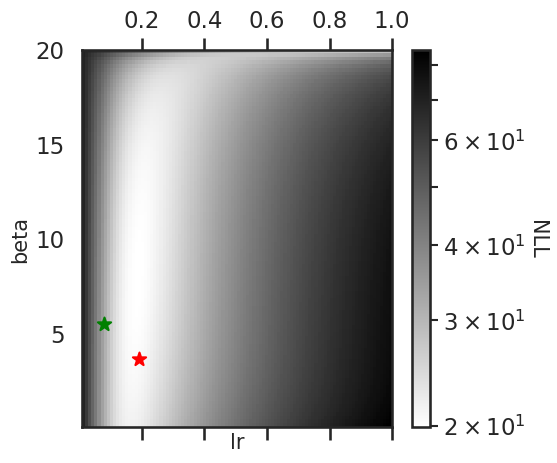

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
im = ax.matshow(NLLS[SUBJ], cmap='gray_r', extent=[lr_range[0], lr_range[1], beta_range[0], beta_range[1]], aspect='auto',norm=LogNorm(vmin=NLLS[SUBJ].min(), vmax=NLLS[SUBJ].max()))
ax.scatter(data.loc[SUBJ].true_lr, data.loc[SUBJ].true_beta, c='green', marker='*', s=100)
ax.scatter(lrs[best_beta_idx], betas[best_beta_idx], c='red', marker='*', s=100)
ax.set_ylabel(ylabel='beta', fontsize=15)
ax.set_xlabel(xlabel='lr', fontsize=15)
cbar=plt.colorbar(mappable=im, ax=ax)
cbar.set_label('NLL', rotation=270, fontsize=15, labelpad=15)
plt.show()

### compute NLL per subj across parameters (speed-up)

TODO: 
- need to pass vector of parameters to the nll computer

In [220]:
q=torch.tensor([[0.5, 0.5],[0.5, 0.5],[0.5, 0.5]])

In [221]:
lr = torch.tensor([0.1, 0.5, 2]).reshape(-1,1)
beta= torch.tensor([1, 2, 3]).reshape(-1,1)

In [249]:
def nll_per_subject(outcomes, qq, lr, beta, choice, ntrials=1000):
    nll = 0.
    for trial in range(ntrials):
        a_t = choice[trial]
        nll += -(qq[:, a_t].reshape(-1,1)*beta - np.log(np.exp(qq*beta).sum(1)).reshape(-1,1))
        r_t = outcomes[trial][a_t]
        c = (qq[:, a_t].reshape(-1,1)+ (r_t-q[:, a_t]).reshape(-1,1)*lr).reshape(len(lr))
        
    return nll

In [252]:
nll_per_subject(outcome, q, lr, beta, action)

tensor([[ 382.1781],
        [ 182.5676],
        [1539.0000]])

## confidence interval for parameters

Note: too laborious to compute by hand but one potential way to do it would be tracking forward gradients